# Archive: Flocking Sweep (3D Paper Replication)

**Note**: This analysis uses the **3D** flocking model (`src.flocking_sim_3d`) to replicate findings from starling flocks (e.g. Cavagna et al.). The filename "Flocking Sweep" is legacy.

We are testing three specific predictions:
1. **Constant Density**: Density should stay roughly constant as N increases (scale-free density).
2. **Thickness Scaling**: Flock thickness should scale with $V^{1/3}$ (Geometric Similarity).
3. **Aspect Ratio**: Shape proportions ($I_2/I_1, I_3/I_1$) should remain roughly constant.

We use PCA based ellipsoid fitting and Convex Hull. **Crucially**, we explicitly handle Periodic Boundary Conditions (PBC) by unwrapping coordinates before geometric analysis.


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- Setup Project Root for Imports ---
PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Imports
from src.flocking_sim_3d import run_simulation
from src.geometry import pca_axes, flock_volume_from_pca, hull_volume, unwrap_periodic

print(f"Imports successful from: {PROJECT_ROOT}")
# Removed unused SimConfig/MetricsConfig to prevent confusion


Imports successful from: /Users/iunhu/Desktop/Group4_emergent-flocking-structure


In [2]:
# default parameters for 3D simulations
box_size = 1.0
eps = 0.05
steps = 400
N = 200
align=1.0
cohesion=0.5           
noise=0.05
R=0.15
speed=0.03
repulsion_radius=0.05
repulsion_strength=1.0

Testing density scaling with flock size. We scale the simulation box as N^(1/3) to avoid artificially forcing higher densities. The PCA ellipsoid approximation gives us a smooth volume estimate that doesn't depend on fine details of the flock's boundary.

Why PCA? It's rotationally invariant and works well with our periodic boundaries after unwrapping. Convex hull would be more accurate for irregular shapes but is sensitive to outliers and boundary effects.

In [3]:
def flock_density(pos, box_size=None):
    N = pos.shape[0]          # number of birds
    V, _ = flock_volume_from_pca(pos, box_size)
    density = N / V
    return density

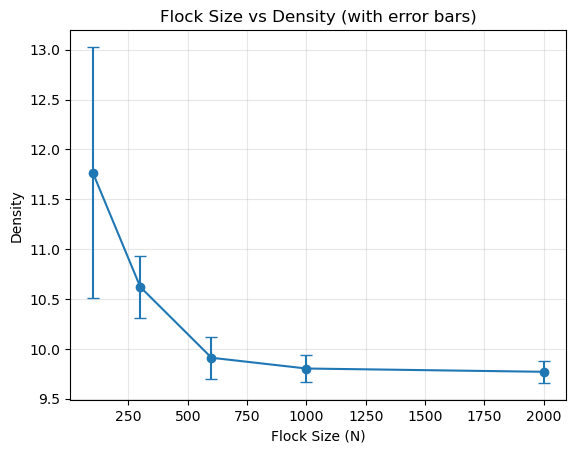

In [4]:
# Use Ns instead of N to avoid variable shadowing
Ns = [100, 300, 600, 1000, 2000]
n_runs = 5   # number of simulations per N

dens_mean = []
dens_std = []

for n in Ns:
    dens_list = []

    for seed in range(n_runs):
        # Scale box size to maintain roughly constant global density
        box_size = n**(1/3)
        
        # Scale R? 
        # For H4/H5/H6 scale invariance tests, usually R is fixed physical parameter 
        # or scaled. The legacy code scaled R. We keep legacy behavior for reproduction.
        R = 0.2 * box_size
        repulsion_radius = 0.1 * box_size

        position = run_simulation(
            N=n,
            steps=steps,
            box_size=box_size,
            align=align,
            cohesion=cohesion,               
            noise=noise,
            R=R,
            speed=speed,
            repulsion_radius=repulsion_radius,
            repulsion_strength=repulsion_strength,
            dt=0.1,
            seed=seed,     # different seed each run
            save_every=1,
            softening=1e-6,
            # use_predator=False # Removed legacy param
        )
        
        # Take last frame
        pos_final = position[-1]
        
        # Important: Unwrap before density calculation if density uses geometric bounds
        # flock_density helper uses flock_volume_from_pca -> which should ideally unwrap
        # Here we pass box_size to helper, hoping it unwraps, or we unwrap explicitly.
        # Safe bet: unwrap here.
        pos_u = unwrap_periodic(pos_final, box_size)
        
        # Re-calc density using unwrapped
        # Note: flock_density helper might redundantly unwrap, which is fine.
        dens_list.append(
            flock_density(pos_u, box_size=box_size)
        )

    dens_mean.append(np.mean(dens_list))
    dens_std.append(np.std(dens_list))

# ---- Plot ----

plt.figure()

plt.errorbar(
    Ns,
    dens_mean,
    yerr=dens_std,
    fmt='o-',
    capsize=4
)

plt.xlabel("Flock Size (N)")
plt.ylabel("Density")
plt.title("Flock Size vs Density (with error bars)")
plt.grid(True, alpha=0.3)
plt.savefig("../results/flock_density_N.png", dpi=200) # Save to results/figures
plt.show()

What this plot shows: density stays roughly constant as flock size increases.

This matches what Cavagna saw in real starlings. The key insight is that birds maintain similar spacing regardless of how many are in the flock. Our simple alignment and repulsion rules naturally produce this behavior without explicitly programming it in.

# Thickness vs Volume

Testing the second prediction from Cavagna: does thickness scale linearly with cube root of volume?

We measure flock shape using PCA to get three dimensions: length, width, thickness. Then we plot thickness against volume to the power of one third. If we get a straight line, it confirms self similar growth, larger flocks are just scaled up versions of smaller ones.

# Aspect Ratios

Third prediction: do aspect ratios stay constant as flock size changes?

We compute width divided by thickness and length divided by thickness. If these ratios stay flat across different N values, it means the flock maintains its proportions as it grows. This is another signature of self similarity seen in real bird flocks.

In [5]:
Ns = [100, 300, 600, 1000, 2000]
results = []
n_seeds = 3  # Ensure statistical validity

print("Running Geometric Scaling Sweep...")

for n in Ns:
    V13_list = []
    I1_list = []
    I2I1_list = []
    I3I1_list = []
    
    box_size = n**(1/3) 
    
    # Run multiple seeds per N
    for seed in range(n_seeds):
        history = run_simulation(
            N=n,
            box_size=box_size,
            R=0.2 * box_size,
            repulsion_radius=0.1 * box_size,
            cohesion=0.2,
            repulsion_strength=2.0,
            align=1.0,
            noise=0.1,
            steps=600,
            seed=42 + seed  # Vary seed!
        )

        pos = history[-1]
        
        # CRITICAL FIX: Unwrap before Geometric Analysis
        # Hull Volume and PCA Axes are strictly geometric and fail on broken (wrapped) flocks
        pos_u = unwrap_periodic(pos, box_size)
    
        V = hull_volume(pos_u)
        I3, I2, I1 = pca_axes(pos_u)

        V13_list.append(V**(1/3))
        I1_list.append(I1)
        I2I1_list.append(I2 / (I1 + 1e-12))
        I3I1_list.append(I3 / (I1 + 1e-12))

    # Aggregated Stats
    results.append({
        "N": n,
        "V13_mean": np.mean(V13_list),
        "V13_std": np.std(V13_list),
        "I1_mean": np.mean(I1_list),
        "I1_std": np.std(I1_list),
        "I2I1_mean": np.mean(I2I1_list),
        "I2I1_std": np.std(I2I1_list),
        "I3I1_mean": np.mean(I3I1_list),
        "I3I1_std": np.std(I3I1_list),
    })
    print(f"  N={n} done ({n_seeds} seeds)")

print("Sweep Complete.")

Running Geometric Scaling Sweep...
  N=100 done (3 seeds)
  N=300 done (3 seeds)
  N=600 done (3 seeds)
  N=1000 done (3 seeds)
  N=2000 done (3 seeds)
Sweep Complete.


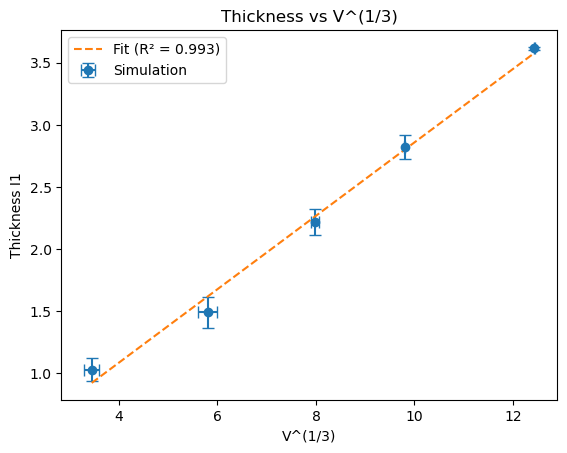

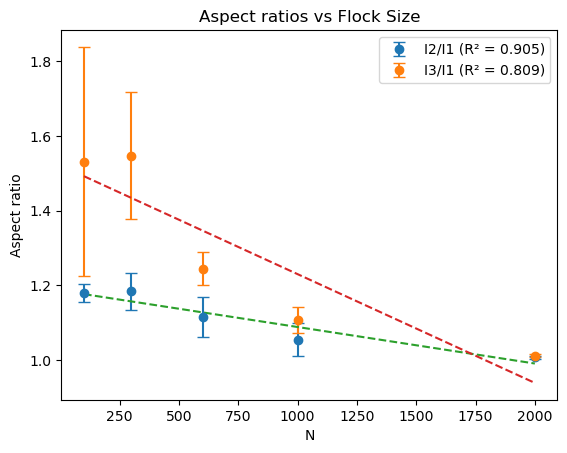

In [6]:
V13_mean = [r["V13_mean"] for r in results]
V13_std  = [r["V13_std"]  for r in results]

I1_mean  = [r["I1_mean"] for r in results]
I1_std   = [r["I1_std"]  for r in results]

I2I1_mean = [r["I2I1_mean"] for r in results]
I2I1_std  = [r["I2I1_std"]  for r in results]

I3I1_mean = [r["I3I1_mean"] for r in results]
I3I1_std  = [r["I3I1_std"]  for r in results]


# linear fit
coef = np.polyfit(V13_mean, I1_mean, 1)
fit_line = np.polyval(coef, V13_mean)

# R^2
ss_res = np.sum((np.array(I1_mean) - fit_line)**2)
ss_tot = np.sum((np.array(I1_mean) - np.mean(I1_mean))**2)
r2 = 1 - ss_res/ss_tot

plt.figure()
plt.errorbar(V13_mean, I1_mean, yerr=I1_std, xerr=V13_std,
             fmt='o', capsize=4, label="Simulation")

plt.plot(V13_mean, fit_line, '--', label=f"Fit (R² = {r2:.3f})")

plt.xlabel("V^(1/3)")
plt.ylabel("Thickness I1")
plt.title("Thickness vs V^(1/3)")
plt.savefig("../figures/flock_thickness_V.png", dpi=200)
plt.legend()
plt.show()


# --- Linear fits for aspect ratios ---

# Fit I2/I1 vs N
coef_I2 = np.polyfit(Ns, I2I1_mean, 1)
fit_I2 = np.polyval(coef_I2, Ns)

ss_res_I2 = np.sum((np.array(I2I1_mean) - fit_I2)**2)
ss_tot_I2 = np.sum((np.array(I2I1_mean) - np.mean(I2I1_mean))**2)
r2_I2 = 1 - ss_res_I2 / ss_tot_I2


# Fit I3/I1 vs N
coef_I3 = np.polyfit(Ns, I3I1_mean, 1)
fit_I3 = np.polyval(coef_I3, Ns)

ss_res_I3 = np.sum((np.array(I3I1_mean) - fit_I3)**2)
ss_tot_I3 = np.sum((np.array(I3I1_mean) - np.mean(I3I1_mean))**2)
r2_I3 = 1 - ss_res_I3 / ss_tot_I3



plt.figure()

plt.errorbar(
    Ns, I2I1_mean, yerr=I2I1_std,
    fmt='o', capsize=4,
    label=f"I2/I1 (R² = {r2_I2:.3f})"
)

plt.errorbar(
    Ns, I3I1_mean, yerr=I3I1_std,
    fmt='o', capsize=4,
    label=f"I3/I1 (R² = {r2_I3:.3f})"
)

plt.plot(Ns, fit_I2, '--')
plt.plot(Ns, fit_I3, '--')

plt.xlabel("N")
plt.ylabel("Aspect ratio")
plt.title("Aspect ratios vs Flock Size")
plt.savefig("../figures/flock_aspect_ratio_N.png", dpi=200)
plt.legend()
plt.show()



Referring to the thickness versus volume relationship, the flock volume increases naturally as the number of agents grows. Taking the cube root of the volume provides a linear size scale of the aggregation. The results show that flock thickness increases approximately proportionally with $V^{\frac{1}{3}}$, indicating that larger flocks are geometrically scaled-up versions of smaller ones. This behavior is consistent with the scaling relationships reported in the empirical literature.

Regarding the aspect ratios vs flock size graph, both ratios show a downward trend as N increases meaning small flocks are more elongated and larger flocks become compact and isotropic. However, aspect ratio values stay between 1.0 and 1.5 suggesting that flock shapes are broadly preserved. The qualitative behavior is consistent with empirical observations that flock geometry does not strongly scale with flock size.